In [123]:
from IPython.display import clear_output
import numpy as np
import sys
import time
import plotly
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from collections import defaultdict
from copy import copy
from tabulate import tabulate
init_notebook_mode(connected=True)

In [124]:
def render_env(location):
    world = ["O"] * 7
    world[location] = "🐭"
    print("{}--{}--{}--{}--{}--{}--{}".format(*world))

In [125]:
def calc_need(energy):
    need = -2 * energy + 200
    return np.min([need, 100])

In [126]:
def get_preferences(action_values, preference=0, debug=False):
    action_values = copy(action_values)
    if debug: print("Action Values", action_values)
    low = np.min(action_values)
    if debug: print("Lowest value", low)
    if low < 0:
        if debug: print('NEGATIVE')
        action_values += low
    # Bound lower values to 1.0
    action_values += 1
    avg = np.mean(action_values)
    averages = np.array([avg] * len(action_values))
    deltas = action_values - avg
    if debug: 
        print("Shifted Action Values", action_values)
        print("Average", avg)
        print("Averages array", averages)
        print("Deltas", deltas)
    deltas *= preference
    tmp = averages + deltas
    total = np.sum(tmp)
    prefs = tmp / total
    if debug: 
        print("Weighted deltas", deltas)
        print("Temp values", tmp)
        print("Total", total)
        print("Prefs", prefs)
    
    return prefs

In [132]:
def choose_action(q_table, energy, location, debug=False):
    # The strength of our need is a function of how much energy we have
    need = calc_need(energy)
    if debug: print(need)
    action_vals = q_table[location]
    actions = range(len(action_vals))
    
    # Our chance of adhereing to existing preferences is a function of need
    preference = act_chance = need / 100
    action = 0
    # preference = 1 # Debug - Make agent adhere to its preferences fully
    prefs = get_preferences(action_vals, preference)
    if debug: print(act_chance)
    act_chance = 1 # Debug - always do something
    if np.random.random() < act_chance:
        action = np.random.choice(actions, p=prefs)
    
    return action

In [133]:
def step_env(location, action):
    if action == 1:
        location = np.max([location - 1, 0])
    if action == 2:
        location = np.min([location + 1, 6])
    cheese = False
    if location == 6 and action == 3:
        cheese = True
        
    return location, cheese

In [134]:
def update_tables(state_table, q_table, location, action, new_location, value, alpha, debug=True):
    
    if debug: print("Prev Location", location, "Action", action, "New Location", new_location, "Value", value)
    
    # How do we think about this location generically?
    state_value = state_table[new_location]
    if debug: print("Initial new_location value", state_value)
    state_delta = value - state_value
    state_value = state_value + alpha * state_delta 
    state_table[new_location] = state_value
    if debug: print("Updated new_location value", state_value)
    
    # How do we think about the previous location generically?
    prev_state_value = state_table[location]
    if debug: print("Initial previous location value", prev_state_value)
    prev_state_delta = state_value - prev_state_value
    prev_state_value = prev_state_value + alpha * (prev_state_delta * abs(prev_state_delta))
    state_table[location] = prev_state_value
    if debug: print("Updated previous location value", prev_state_value)
    
    # How do we think about the action which we took at the previous location?
    q_value = q_table[location][action]
    if debug: print("Previous location-action val", q_value)
    q_delta = value - q_value
    q_value = q_value + alpha * (2 * q_delta)
    q_table[location][action] = q_value
    if debug: print("Updated location-action val", q_value)   
    
    return state_table, q_table

In [135]:
def interpret(state_table, state):
    """
    This should be a generic, learned function but we'll hard code some knowledge here that
    would normally be acquired on an evolutionary timescale.
    """
    
    energy, location, cheese = state
    
    # Cheese is great until we're full
    cheese_val = 0
    if cheese:
        cheese_val = 100 - energy
    
    # Things are good until we're hungry
    # https://www.desmos.com/calculator/zc8dstbyzy
    # DISABLED FOR NOW NOT BEING USED
    # energy_val = -1 * np.exp(-1 * ((energy - 40) / 8.5)) + 1
    # return state_table[location] + energy_val + cheese_val, energy_val
    
    # Try with just the cheese val
    return state_table[location] + cheese_val

In [136]:
# [stay, left, right, eat]
actions = [0, 1, 2, 3]
bmr = 0.01

move_cost = 0.1
cheese_nrg = 5

energy = 100
location = 3

render_env(location)
learning_rate = 0.1

energy_over_time = []
location_over_time = []
# nrg_val_over_time = []

Q = defaultdict(lambda: np.zeros(4))
S = defaultdict(lambda: 0)

state_value_history = []
q_value_history = []


render = False
max_iters = 1000
cheese = False
for i in range(max_iters):
    # Record our progress
    energy_over_time.append(energy)
    location_over_time.append(location)

    # Choose an action
    action = choose_action(Q, energy, location)
    
    # State
    new_location, cheese = step_env(location, action)
    
    # Interpretation
    value = interpret(S, [energy, new_location, cheese])
    # value, nrg_val = interpret(S, [energy, new_location, cheese])
    # nrg_val_over_time.append(nrg_val)
    # print(tabulate([[location, action, new_location, energy, cheese, value]], headers=["Location","Action","New Location","Energy", "Cheese", "Value"]))
    
    # Update our memories
    S, Q = update_tables(S, Q, location, action, new_location, value, learning_rate)
    
    # Record the history of memory states
    state_value_history.append(copy(S))
    q_value_history.append(copy(Q))
    
    # time.sleep(0.01)
    # clear_output(wait=True)
    if render:
        render_env(location)


    # Moving costs energy
    if new_location != location:
        energy -= move_cost
    # We've just eaten some cheese! Modify internal state to reflect that.
    if cheese:
        energy += cheese_nrg
    # Living is costly, pay the base metabolic rate
    energy -= bmr
    
    if energy <=0 or energy >= 200:
        print("DEAD")
        print("Iterations: ", i)
        break

    location = new_location

    
print("Done.")


O--O--O--🐭--O--O--O
Prev Location 3 Action 2 New Location 4 Value 0
Initial new_location value 0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 4 Action 0 New Location 4 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 4 Action 2 New Location 5 Value 0
Initial new_location value 0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 5 Action 0 New Location 5 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 5 Action 0 New Location 5 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 5 Action 1 New Location 4 Value 0.0
Initial new_location value 0.0
Updated new_location v

Prev Location 0 Action 0 New Location 0 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 0 Action 2 New Location 1 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 1 Action 0 New Location 1 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 1 Action 3 New Location 1 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 1 Action 1 New Location 0 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 0 Action 3 New Location 0 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Pre

Updated location-action val 0.0
Prev Location 0 Action 3 New Location 0 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 0 Action 1 New Location 0 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 0 Action 0 New Location 0 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 0 Action 2 New Location 1 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 1 Action 3 New Location 1 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 1 Action 2 New Location 2 Value 0.0
Initial new_location value 0.0
Up

Prev Location 3 Action 2 New Location 4 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 4 Action 2 New Location 5 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 5 Action 0 New Location 5 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 5 Action 1 New Location 4 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 4 Action 0 New Location 4 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 4 Action 0 New Location 4 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Pre

Updated location-action val 0.0
Prev Location 4 Action 2 New Location 5 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 5 Action 3 New Location 5 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 5 Action 3 New Location 5 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 5 Action 1 New Location 4 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 4 Action 3 New Location 4 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 4 Action 2 New Location 5 Value 0.0
Initial new_location value 0.0
Up

Prev Location 3 Action 1 New Location 2 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 2 Action 3 New Location 2 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 2 Action 2 New Location 3 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 3 Action 1 New Location 2 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 2 Action 1 New Location 1 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 1 Action 0 New Location 1 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Pre

Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 2 Action 1 New Location 1 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 1 Action 2 New Location 2 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 2 Action 2 New Location 3 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 3 Action 1 New Location 2 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 2 Action 3 New Location 2 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 2 Action 2 New Location 3 Value 0.0


Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 3 Action 1 New Location 2 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 2 Action 0 New Location 2 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 2 Action 0 New Location 2 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 2 Action 3 New Location 2 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 2 Action 1 New Location 1 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 1 Action 2 New Location 2 Value 0.0


Prev Location 5 Action 1 New Location 4 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 4 Action 0 New Location 4 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 4 Action 0 New Location 4 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 4 Action 2 New Location 5 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 5 Action 3 New Location 5 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 5 Action 0 New Location 5 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Pre

Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 4 Action 0 New Location 4 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 4 Action 0 New Location 4 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 4 Action 2 New Location 5 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 5 Action 0 New Location 5 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 5 Action 1 New Location 4 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 4 Act

Prev Location 3 Action 0 New Location 3 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 3 Action 1 New Location 2 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 2 Action 0 New Location 2 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 2 Action 2 New Location 3 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 3 Action 0 New Location 3 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 3 Action 2 New Location 4 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Pre

Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 4 Action 3 New Location 4 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 4 Action 1 New Location 3 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 3 Action 2 New Location 4 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 4 Action 0 New Location 4 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 4 Action 2 New Location 5 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-act

Prev Location 3 Action 1 New Location 2 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 2 Action 3 New Location 2 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 2 Action 0 New Location 2 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 2 Action 1 New Location 1 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 1 Action 0 New Location 1 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 1 Action 0 New Location 1 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Pre

Initial new_location value -35.14900000000134
Updated new_location value -38.49600000000209
Previous location-action val -51.81515524265248
Updated location-action val -55.17592419412376
Prev Location 6 Action 2 New Location 6 Value -38.49600000000209
Initial new_location value -38.49600000000209
Updated new_location value -38.49600000000209
Previous location-action val -26.401180985252058
Updated location-action val -28.820144788202064
Prev Location 6 Action 2 New Location 6 Value -38.49600000000209
Initial new_location value -38.49600000000209
Updated new_location value -38.49600000000209
Previous location-action val -28.820144788202064
Updated location-action val -30.75531583056207
Prev Location 6 Action 0 New Location 6 Value -38.49600000000209
Initial new_location value -38.49600000000209
Updated new_location value -38.49600000000209
Previous location-action val -29.492164642704847
Updated location-action val -31.292931714164297
Prev Location 6 Action 3 New Location 6 Value -76.92

Prev Location 0 Action 2 New Location 1 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 1 Action 3 New Location 1 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 1 Action 1 New Location 0 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 0 Action 3 New Location 0 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 0 Action 0 New Location 0 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Previous location-action val 0.0
Updated location-action val 0.0
Prev Location 0 Action 1 New Location 0 Value 0.0
Initial new_location value 0.0
Updated new_location value 0.0
Pre

In [100]:
trace1 = go.Scatter(
    y=energy_over_time,
    name='energy'
)
trace2 = go.Scatter(
    y=location_over_time,
    yaxis='y2',
    name='location'
)
# trace3 = go.Scatter(
#     y=nrg_val_over_time,
#     name='hunger penalty'
# )

# data = [trace1, trace2, trace3]
data = [trace1, trace2]
layout = go.Layout(
    title='Double Y Axis Example',
    yaxis2=dict(
        title='Locations',
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right'
    )
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='multiple-axes-double')

In [101]:
data = []
for i in range(7):
    vals = [s[i] for s in state_value_history]
    trace = go.Scatter(
        y=vals
    )
    data.append(trace)

iplot(data)


In [102]:
data = []
for i in range(7):
    for j in range(4):
        vals = [q[i][j] for q in q_value_history]
        trace = go.Scatter(
            y=vals,
            name="State {} action {}".format(i, j)
        )
        data.append(trace)

iplot(data)

In [103]:
action_values = []
for k, vs in Q.items():
    short_vs = []
    for v in vs:
        short_vs.append(round(v, 2))
    action_values.append(short_vs)
action_values = np.array(action_values).T

x=['0', '1', '2', '3', '4', '5', '6']
y=['A-0', 'A-1', 'A-2', 'A-3']
fig = ff.create_annotated_heatmap(action_values, x=x, y=y)
iplot(fig)

Food - Too little. You Die. Too much. You die.
Need - Motivation to find food.

### State, Interpretation, Value, Action

A state is composed of the observable portions of the environment and the agent's internal state.

Interpretation of that state results in an evaluation which may be positive, neutral, negative, or some combination of all three.

The agent then either does nothing or selects an action based on the evaluation of its current state, its policy, and its current needs.

## A mouse in a maze

Imagine we have a mouse. We want to this mouse to learn to solve a maze. 

Now this maze is going going to be very simple. It's just going to be a long hallway.

The mouse will start at one side of the hallway and there will be cheese at the other end.

To make this simple to program we're going to make the hallway a series of seven sections. The mouse will start in the first section and the cheese will be in the last section, the end of the hallway.

Now imagine that when we put the mouse in the maze it's actually full, and warm and happy. Do you expect the mouse to move a lot, a little, or not much at all?

Depending on just how comfortable the mouse is it probably won't move much. But it takes energy just to stay alive and so after a while the mouse is going to start to get hungry.

Here we've identified two important concepts. The energy level of the mouse and how hungry the mouse is.

As the energy reserves of the mouse decrease the hunger of the mouse will increase.

When the energy reserves of the mouse are full it doesn't need to move much and so probably won't. (Real mice have other drives, like curiosity, but this is a very dull mouse).

Now real mice can move in any direction, control hundreds of muscles, and do all sorts of amazing things. Our virtual mouse is going to be much more limited. It can do 1 of 4 things. It can do nothing, move left, move right, or gnaw on something around it.

As mentioned earlier when energy is high it will probably do nothing, but as it gets hungry it will have the motivation to do one of the other things to do more frequently. Real mice probably have innate preferences for which one they would do more, but here we'll start out choosing randomly between the other options. 

As the mouse's hunger increases and it starts to move more and more it may eventually find itself (by chance) in the last section of the hallway where it decides to gnaw on something. This results in a revelation! Cheese! 

The act of gnawing on things in the last section results in the delicious taste of cheese. 

Because the mouse is still hungry it takes another bite and another until it's full. Now imagine what happens to the level of enjoyment of eating the cheese as the mouse eats more and more. We would expect it to decrease. Eventually if the mouse is full to bursting, if it took another bite of cheese that bite might even taste unpleasant.

Once the mouse has eaten its fill it will stop eating.

Over time the mouse will digest and (just by living) use energy and get hungry again. When it's not full but not yet very hungry it might explore the maze a bit more, moving more or less randomly. As soon as it gets actually hungry however the mouse should immediately find its way back to the cheese (don't worry the cheese can't run out in our little world) and eat as much as it wants.

Finally, to say that the mouse has learned how to solve this maze, if we put a hungry version of the mouse anywhere in the maze it should immediately run to the cheese and start eating without going the wrong direction.

If it can it has learned how to fulfil its need.




### Limiting Factors

- If need is 0 the mouse doesn't act. Not realistic
- If energy is high the perceived value of cheese is low.
- If energy is maxed the perceived value of cheese is negative.

The third is never invoked currently.

### This is what a smart mouse looks like
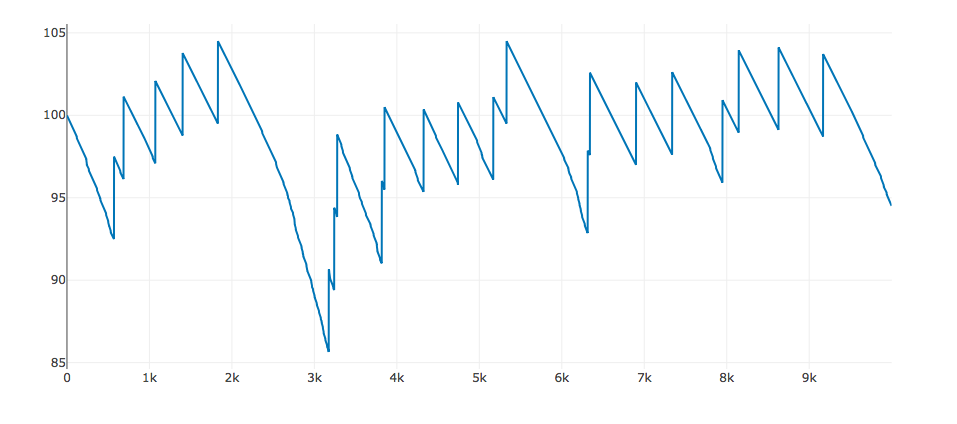

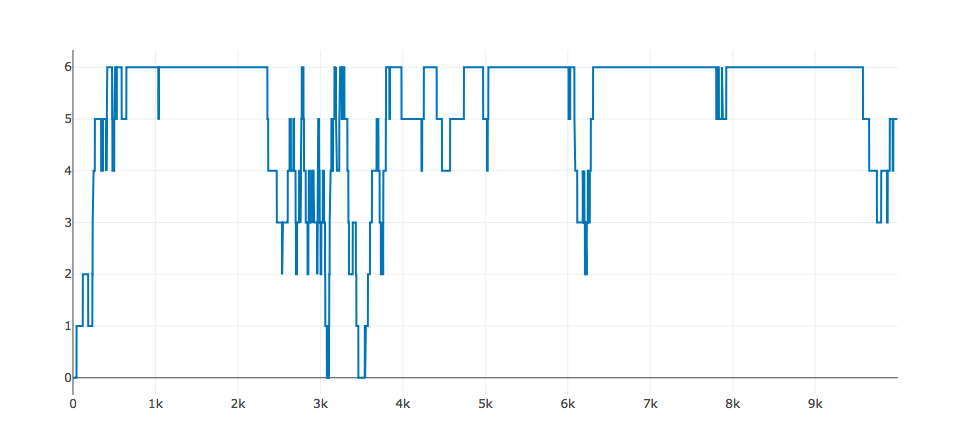

### Double Duty Q-Table

In RL the Q-Table has multiple concerns

1. Prediction/Evaluation/Memory - It estimates the expected return of selecting an action in a given state.
2. Action Selection - It helps determine which action will be selected.

These are seperable, one might even say orthogonal, concerns.

In biology the root of action is spiking neurons. If a single neuron controls a single muscle, action selection is equivalent to whether or not that neuron is firing rapidly enough to activate the muscle.

The fundamental learning rule for neurons is spike-timing-dependant-plasticity. If a neuron fires just prior to another neuron becoming active the synapse between the two will be strengthened. If a neuron fires just *after* another neuron the synapse between the two will be weakened.

This rule says nothing about the evaluation of a resulting state.

The definition of reinforcement however is that a stimulus causes a behavior to occur more frequently.

One mechanism focuses on prediction. The other on evaluation.

Two Postulates

 - Evaluation makes prediction easier.
 - Evaluation changes how synaptic weights are updated.
 
 
 For postulate 1 you could be a passive passenger watching states unfold. This is good, I expect more good etc. If you perfectly predict the next state, and its value, that still doesn't interact with why a behavior occurs more frequently.
 
 Additionally evaluation of outcomes is slow. There isn't time in most decisions for anything other than feed forward action, meaning that, in one pass, inputs have to produce correct behavior.
 
 Like water flowing down a well worn channel it will simply progress without intervention or forward simulation of the 'best' path.
 
 That leaves postulate 2. An action with an extremely predictable *bad* outcome has to occur less than alternate actions with moderate outcomes. The act of evaluation needs to preferentially select some actions over others.
 
 